# Timing Analysis

This notebook is to look at potentially optimizing some features of the rsatoolbox. While I'm super happy to see the toolbox, it is at present very slow and not optimized for searchlight analysis. This notebook is to demonstrate some potential improvements.

In [1]:
import time
import numpy as np
import rsatoolbox as rsa # not sure what convention is
from tqdm import tqdm
from scipy.io import loadmat
from rsatoolbox.data.dataset import Dataset

In [2]:
# Load dataset
dsets = np.load('data.npy') # Subject data
lh_rois = loadmat('lh_rois.mat')['cat_lhROIs'] # Searchlight vertices
print(dsets.shape)    # 18 subjects, 300 words * 6 presentations, 59412 surface vertices
print(lh_rois.shape)  # Each row is binary vector for patch around vertex

# Generate Word and presentation numbers
words = []; presentation = [];
for i in range(1800):
    words.append(f'_{int(i/6)}_')
    presentation.append(np.mod(i,6))
even_odd = np.mod(presentation,2)

(18, 1800, 59412)
(29696, 29696)


The general task will be to loop over each subject, and each vertex. The following code seems to be one method of doing that. We will do it for just 10 vertices to start

In [3]:
lh_ds = [];
for i in range(len(dsets)):
    tmp    = dsets[i][:,:29696]
    tmp_ds = Dataset(measurements = tmp,
             descriptors = {'subj':i},
             obs_descriptors = {'words':words, 'presentation':presentation, 'run':even_odd},
             channel_descriptors={'vertices':np.arange(29696)})
    lh_ds.append(tmp_ds)

In [4]:
def lh_searchlight(i):
    neighbors = np.nonzero(lh_rois[i])[0]
    rdms_data = []
    for j in range(len(dsets)): # Iterate over subjects
        sdata = lh_ds[j].subset_channel('vertices',neighbors)
        tmp = rsa.rdm.calc_rdm(sdata, descriptor='words',method='crossnobis',
                                cv_descriptor='run')
        rdms_data.append(tmp)
    rdms_data = rsa.rdm.rdms.concat(rdms_data)
    return rdms_data

In [5]:
start = time.time()
tmp = [lh_searchlight(i) for i in range(10)]
print(f'Elapsed Time:{time.time() - start:.1f} seconds')

Elapsed Time:58.6 seconds


We can see that just 10 vertices takes a minue! That's 6 seconds per vertex. This is on a decent machine as well. This is just to calculate the RDM and not evaluate it. Just calculating the RDM's would take **100 hours**

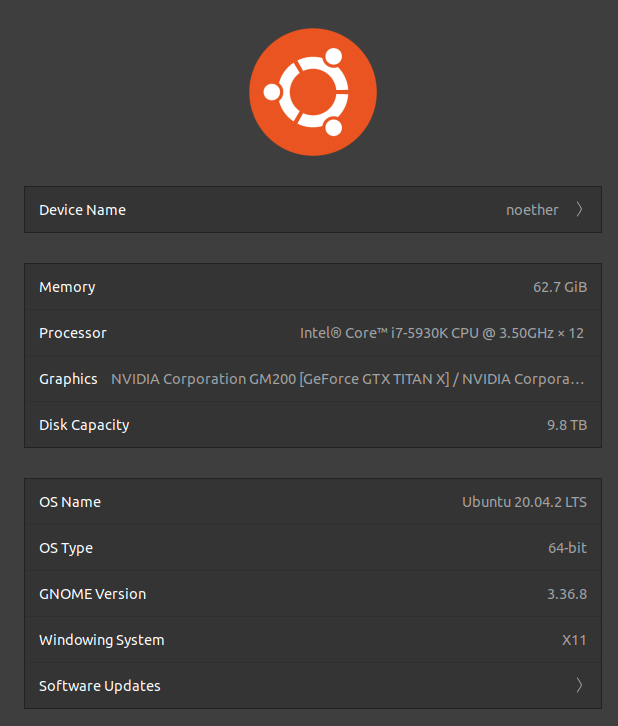

To understand this better, I ran a profiler on the above code

In [6]:
import cProfile, pstats
cp = cProfile.Profile()
cp.enable()
tmp = [lh_searchlight(i) for i in range(10)]
cp.disable()
stats = pstats.Stats(cp).sort_stats('cumtime')
stats.print_stats()

         17845766 function calls (17835836 primitive calls) in 60.758 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   60.758   30.379 /home/smazurchuk/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3396(run_code)
        2    0.000    0.000   60.758   30.379 {built-in method builtins.exec}
        1    0.000    0.000   60.758   60.758 <ipython-input-6-996d8ff903f3>:4(<module>)
        1    0.001    0.001   60.758   60.758 <ipython-input-6-996d8ff903f3>:4(<listcomp>)
       10    0.009    0.001   60.757    6.076 <ipython-input-4-1161255aba01>:1(lh_searchlight)
      180    0.005    0.000   45.076    0.250 /home/smazurchuk/anaconda3/lib/python3.8/site-packages/rsatoolbox/rdm/calc.py:18(calc_rdm)
      180    0.148    0.001   44.899    0.249 /home/smazurchuk/anaconda3/lib/python3.8/site-packages/rsatoolbox/rdm/calc.py:256(calc_rdm_crossnobis)
      900    0.007    0.000  

Noticing that much of the time is spent on `split_obs` I thought I would use numpy to do the initial selection and move the creation of the subject_dsm (`sdata`) to inside of the loop

In [7]:
def lh_searchlight2(i):
    rdms_data = []; 
    neighbors = np.nonzero(lh_rois[i])[0]
    for j in range(len(dsets)):
        ds = Dataset(measurements = dsets[j][:,:29696][:,neighbors],
                 descriptors = {'subj':i, 'center':j},
                 obs_descriptors = {'words':words, 'presentation':presentation, 'run':even_odd})
        tmp = rsa.rdm.calc_rdm(ds, descriptor='words',method='crossnobis',
                                cv_descriptor='run')
        rdms_data.append(tmp)
    return rdms_data

In [8]:
start = time.time()
tmp = [lh_searchlight2(i) for i in range(10)]
print(f'Elapsed Time:{time.time() - start:.1f} seconds')

Elapsed Time:42.2 seconds


We can see moderate improvement (28%)! Clearly, we can see a major cause of the problem. If we profile the code again, we can see that `split_obs` is still a major cpu hog. For brevity, I will skip printing the output here. From the initial `cProfile` printout, we can see that most of the time time was spent at line 205 in the dataset.py file. Below is the code at that line:

```python
class Dataset(DatasetBase):
    """
    Dataset class is a standard version of DatasetBase.
    It contains one data set - or multiple data sets with the same structure
    """

    def split_obs(self, by):
        """ Returns a list Datasets splited by obs

        Args:
            by(String): the descriptor by which the splitting is made

        Returns:
            list of Datasets, splitted by the selected obs_descriptor
        """
        unique_values = get_unique_unsorted(self.obs_descriptors[by])
        dataset_list = []
        for v in unique_values:
            selection = [idx for idx, des in enumerate(self.obs_descriptors[by])
                          if des == v]
            measurements = self.measurements[selection, :]
            descriptors = self.descriptors
            obs_descriptors = subset_descriptor(
                self.obs_descriptors, selection)
            channel_descriptors = self.channel_descriptors
            dataset = Dataset(measurements=measurements,
                              descriptors=descriptors,
                              obs_descriptors=obs_descriptors,
                              channel_descriptors=channel_descriptors)
            dataset_list.append(dataset)
        return dataset_list
```

It is the list comprehension here that most time is spent (potentially 26 seconds of the minute)! Surely this could be faster simply as numpy indexing operation.